# Image Classification challange AN2DL Politecnico di Milano 2022
This is ..


## Define the environment
1. **Colab**: the notebook must be in a folder where there is a folder called `data` and the `zip` file containing the training data inside (i.e. `data/training_dataset_homework1.zip`).
2. **Local**: extract the `zip` file containing the training data in `data/training_data_final`

In [27]:
IS_COLAB = True
COLAB_BASE_DIR = '/gdrive/MyDrive/colab/AN2DL1/'
USE_WHOLE_DATASET = True # if True do not perform validation and analysis, just train with all the data

## Libraries import

In [28]:
import os
import enum
import json
from datetime import datetime
import random
from typing import Tuple, Callable, Dict, Optional, List

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Check device
tf.test.gpu_device_name()

'/device:GPU:0'

### Seed

In [29]:
# Random seed for reproducibility
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED) 

### Mount Google Drive (if using Colab)

In [30]:
if IS_COLAB:
    from google.colab import drive
    drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Check folders

In [31]:
ROOT_DIR = os.getcwd()
DATA_DIR = 'data/training_data_final'

if IS_COLAB:
  if not os.path.exists('data'):
    !mkdir 'data'
  if not os.path.isfile('data/training_dataset_homework1.zip'):
    zip_source = COLAB_BASE_DIR + 'data/training_dataset_homework1.zip'
    !cp $zip_source 'data'
  if not os.path.exists(DATA_DIR):
    !unzip 'data/training_dataset_homework1' -d 'data'
else:
  if not os.path.exists('data'):
    raise RuntimeError("data/training_data_final path not found.")
  if not os.path.exists(DATA_DIR):
    raise RuntimeError("please unzip data/training_dataset_homework1.zip")

## Load datasets

Define datasets hyperparameters

In [32]:
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64

In [33]:
IMG_SIZE = (96, 96)
IMG_SHAPE = IMG_SIZE + (3,)
N_CLASSES = 8

if USE_WHOLE_DATASET:
  complete_ds = tf.keras.utils.image_dataset_from_directory(
      DATA_DIR,
      labels='inferred',
      label_mode='int',
      color_mode='rgb',
      batch_size=BATCH_SIZE,
      image_size=IMG_SIZE,
      shuffle=True,
      seed=SEED,
  )
else:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True,
        seed=SEED,
        validation_split=VALIDATION_SPLIT,
        subset = 'training'
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True,
        seed=SEED,
        validation_split=VALIDATION_SPLIT,
        subset = 'validation'
    )

Found 3542 files belonging to 8 classes.
Found 3542 files belonging to 8 classes.
Using 2834 files for training.
Found 3542 files belonging to 8 classes.
Using 708 files for validation.


Configure the dataset for performance, see the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) guide:

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

if USE_WHOLE_DATASET:
  complete_ds = complete_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
else:
  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Preprocessing and Data Augmentation

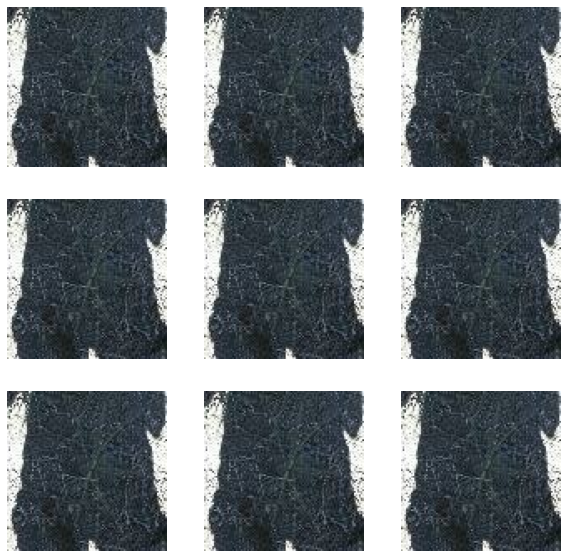

In [35]:
data_augmentation_layer = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomContrast(0.1),
  #tf.keras.layers.RandomBrightness(0.01),
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.RandomTranslation(0.1, 0.1)
], name='data_augmentation')

for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation_layer(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Base model

In [36]:
if USE_WHOLE_DATASET:
  BASE_MODEL_EPOCHS = 39

BASE_MODEL_LEARNING_RATE = 5e-3
BASE_MODEL_OPTIMIZER = tf.keras.optimizers.Adam(BASE_MODEL_LEARNING_RATE)
BASE_MODEL_LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
BASE_MODEL_EARLY_STOPPING_PATIENCE = 10

In [37]:
base_model_supernet = tf.keras.applications.EfficientNetV2B0(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)
base_model_supernet.trainable = False

In [38]:
base_model = tf.keras.Sequential([
    tf.keras.Input(shape=IMG_SHAPE, name="input"),
    data_augmentation_layer,
    #tf.keras.layers.Rescaling(1./127.5, offset=-1),
    base_model_supernet,
    #tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(SEED)),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(SEED)),
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(SEED)),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(SEED)),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(SEED)),
    tf.keras.layers.Dense(N_CLASSES, name='output', activation='softmax', kernel_initializer=tf.keras.initializers.GlorotUniform(SEED))
], name="base_model")

In [39]:
base_model.compile(
    optimizer=BASE_MODEL_OPTIMIZER,
    loss=BASE_MODEL_LOSS,
    metrics=['accuracy']
)
base_model.summary()

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 96, 96, 3)        0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, 3, 3, 1280)       5919312   
 al)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 3, 3, 1280)       5120      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 3, 3, 1280)        0         
                                                                 
 flatten_1 (Flatten)         (None, 11520)             0         
                                                        

### Training

In [40]:
if USE_WHOLE_DATASET:
  base_model_history = base_model.fit(
    complete_ds,
    epochs=BASE_MODEL_EPOCHS
  )
else:
  # use early stopping
  base_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=BASE_MODEL_EARLY_STOPPING_PATIENCE, restore_best_weights=True)
  base_model_history = base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks = [base_model_early_stopping],
  )

Epoch 1/39


56/56 [==============================] - 47s 645ms/step - loss: 2.9487 - accuracy: 0.3303
Epoch 2/39
56/56 [==============================] - 36s 639ms/step - loss: 1.3267 - accuracy: 0.5217
Epoch 3/39
56/56 [==============================] - 36s 635ms/step - loss: 1.1539 - accuracy: 0.5889
Epoch 4/39
56/56 [==============================] - 36s 637ms/step - loss: 1.1273 - accuracy: 0.6033
Epoch 5/39
56/56 [==============================] - 37s 664ms/step - loss: 1.0822 - accuracy: 0.6251
Epoch 6/39
56/56 [==============================] - 36s 637ms/step - loss: 1.0422 - accuracy: 0.6505
Epoch 7/39
56/56 [==============================] - 36s 634ms/step - loss: 1.0207 - accuracy: 0.6575
Epoch 8/39
56/56 [==============================] - 35s 630ms/step - loss: 0.9807 - accuracy: 0.6581
Epoch 9/39
56/56 [==============================] - 36s 634ms/step - loss: 0.9468 - accuracy: 0.6776
Epoch 10/39
56/56 [==============================] - 35s 633ms/step - loss: 0.9406 - accuracy: 0.6790


### Visualize performance

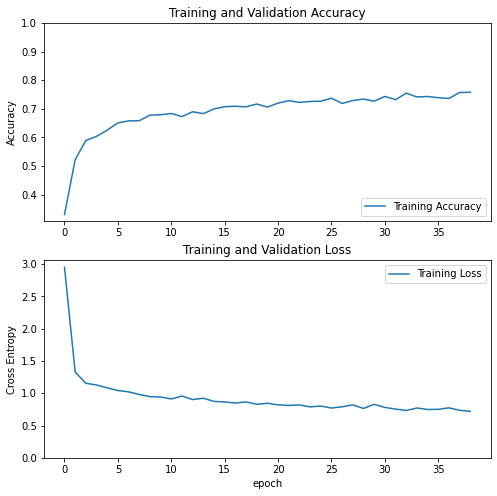

In [41]:
acc = base_model_history.history['accuracy']
if not USE_WHOLE_DATASET:
  val_acc = base_model_history.history['val_accuracy']

loss = base_model_history.history['loss']
if not USE_WHOLE_DATASET:
  val_loss = base_model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
if not USE_WHOLE_DATASET:
  plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
if not USE_WHOLE_DATASET:
  plt.plot([base_model_early_stopping.best_epoch,base_model_early_stopping.best_epoch], plt.ylim(), label='Best Epoch')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
if not USE_WHOLE_DATASET:
  plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,max(plt.ylim())])
if not USE_WHOLE_DATASET:
  plt.plot([base_model_early_stopping.best_epoch,base_model_early_stopping.best_epoch], plt.ylim(), label='Best Epoch')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Save model

In [42]:
base_model_directory = f'models/{base_model_supernet.name}-{datetime.today().strftime("%Y-%m-%d-%H-%M-%S")}'
base_model.save(base_model_directory)

## Fine tuning

In [48]:
if USE_WHOLE_DATASET:
  FT_MODEL_EPOCHS = 71

FT_MODEL_LEARNING_RATE = 5e-5
FT_MODEL_OPTIMIZER = tf.keras.optimizers.Adam(FT_MODEL_LEARNING_RATE)
FT_MODEL_LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
FT_MODEL_EARLY_STOPPING_PATIENCE = 10
FT_MODEL_N_UNFREEZE = 30

### Reload model

In [49]:
ft_model = tf.keras.models.load_model(base_model_directory)
ft_model.summary()
print("Number of layers in the supernet: ", len(ft_model.get_layer(base_model_supernet.name).layers))

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 96, 96, 3)        0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, 3, 3, 1280)       5919312   
 al)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 3, 3, 1280)       5120      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 3, 3, 1280)        0         
                                                                 
 flatten_1 (Flatten)         (None, 11520)             0         
                                                        

### Unfreeze some layers

In [50]:
ft_model.get_layer(base_model_supernet.name).trainable = True

unfreezed = 0
for i in reversed(range(len(ft_model.get_layer(base_model_supernet.name).layers))):
  layer = ft_model.get_layer(base_model_supernet.name).layers[i]
  if layer.name == 'block6d_se_excite':
      layer.trainable = True
  elif unfreezed < FT_MODEL_N_UNFREEZE and not isinstance(layer, tf.keras.layers.BatchNormalization):
      unfreezed += 1
      layer.trainable = True
  else:
    layer.trainable = False
  
  print(i, layer.name, layer.trainable)


ft_model.summary()

269 top_activation True
268 top_bn False
267 top_conv True
266 block6h_add True
265 block6h_drop True
264 block6h_project_bn False
263 block6h_project_conv True
262 block6h_se_excite True
261 block6h_se_expand True
260 block6h_se_reduce True
259 block6h_se_reshape True
258 block6h_se_squeeze True
257 block6h_activation True
256 block6h_bn False
255 block6h_dwconv2 True
254 block6h_expand_activation True
253 block6h_expand_bn False
252 block6h_expand_conv True
251 block6g_add True
250 block6g_drop True
249 block6g_project_bn False
248 block6g_project_conv True
247 block6g_se_excite True
246 block6g_se_expand True
245 block6g_se_reduce True
244 block6g_se_reshape True
243 block6g_se_squeeze True
242 block6g_activation True
241 block6g_bn False
240 block6g_dwconv2 True
239 block6g_expand_activation True
238 block6g_expand_bn False
237 block6g_expand_conv True
236 block6f_add True
235 block6f_drop True
234 block6f_project_bn False
233 block6f_project_conv True
232 block6f_se_excite True
23

### Compile and train

In [51]:
ft_model.compile(
    optimizer=FT_MODEL_OPTIMIZER,
    loss=FT_MODEL_LOSS,
    metrics=['accuracy']
)
ft_model.summary()

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 96, 96, 3)        0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, 3, 3, 1280)       5919312   
 al)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 3, 3, 1280)       5120      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 3, 3, 1280)        0         
                                                                 
 flatten_1 (Flatten)         (None, 11520)             0         
                                                        

In [52]:
if USE_WHOLE_DATASET:
  ft_history = ft_model.fit(
    complete_ds,
    epochs=FT_MODEL_EPOCHS,
    initial_epoch=BASE_MODEL_EPOCHS
  )
else:
  # use early stopping
  ft_max_epochs = 100
  ft_total_epochs =  base_model_early_stopping.best_epoch + ft_max_epochs

  ft_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=FT_MODEL_EARLY_STOPPING_PATIENCE, restore_best_weights=True)

  ft_history = ft_model.fit(
      train_ds,
      epochs=ft_total_epochs,
      initial_epoch=base_model_early_stopping.best_epoch,
      validation_data=val_ds,
      callbacks = [ft_early_stopping]
  )

Epoch 40/71


56/56 [==============================] - 48s 670ms/step - loss: 0.6843 - accuracy: 0.7660
Epoch 41/71
56/56 [==============================] - 36s 645ms/step - loss: 0.6281 - accuracy: 0.7888
Epoch 42/71
56/56 [==============================] - 36s 645ms/step - loss: 0.6155 - accuracy: 0.7902
Epoch 43/71
56/56 [==============================] - 36s 636ms/step - loss: 0.6185 - accuracy: 0.7823
Epoch 44/71
56/56 [==============================] - 36s 638ms/step - loss: 0.5924 - accuracy: 0.7914
Epoch 45/71
56/56 [==============================] - 36s 637ms/step - loss: 0.5769 - accuracy: 0.7987
Epoch 46/71
56/56 [==============================] - 36s 637ms/step - loss: 0.5825 - accuracy: 0.7919
Epoch 47/71
56/56 [==============================] - 37s 668ms/step - loss: 0.5625 - accuracy: 0.8012
Epoch 48/71
56/56 [==============================] - 36s 636ms/step - loss: 0.5787 - accuracy: 0.8010
Epoch 49/71
56/56 [==============================] - 36s 642ms/step - loss: 0.5493 - accuracy:

### Visualize results

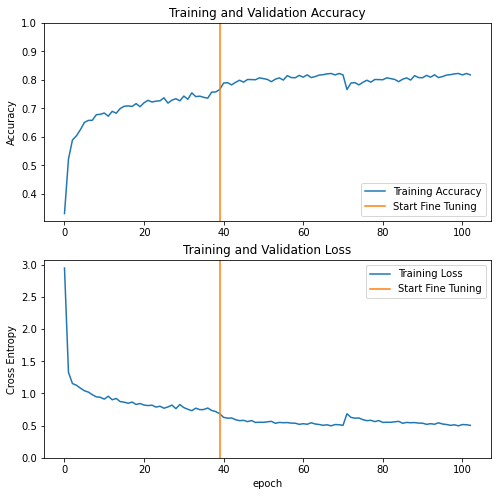

In [54]:
acc += ft_history.history['accuracy']
if not USE_WHOLE_DATASET:
  val_acc += ft_history.history['val_accuracy']

loss += ft_history.history['loss']
if not USE_WHOLE_DATASET:
  val_loss += ft_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
if not USE_WHOLE_DATASET:
  plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
if not USE_WHOLE_DATASET:
  plt.plot([ft_early_stopping.best_epoch,ft_early_stopping.best_epoch],
         plt.ylim(), label='Best Epoch')
if not USE_WHOLE_DATASET:
  plt.plot([base_model_early_stopping.best_epoch, base_model_early_stopping.best_epoch],
          plt.ylim(), label='Start Fine Tuning')
else:
  plt.plot([BASE_MODEL_EPOCHS, BASE_MODEL_EPOCHS],
          plt.ylim(), label='Start Fine Tuning')

plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
if not USE_WHOLE_DATASET:
  plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,max(plt.ylim())])
if not USE_WHOLE_DATASET:
  plt.plot([ft_early_stopping.best_epoch,ft_early_stopping.best_epoch],
         plt.ylim(), label='Best Epoch')
if not USE_WHOLE_DATASET:
  plt.plot([base_model_early_stopping.best_epoch, base_model_early_stopping.best_epoch],
          plt.ylim(), label='Start Fine Tuning')
else:
  plt.plot([BASE_MODEL_EPOCHS, BASE_MODEL_EPOCHS],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Save model

Save newly trained fine tuned model

In [55]:
ft_model_directory = f'models/{base_model_supernet.name}-finetuned-{datetime.today().strftime("%Y-%m-%d-%H-%M-%S")}'
ft_model.save(ft_model_directory)
if IS_COLAB:
  from shutil import make_archive, copyfile
  make_archive(ft_model_directory, 'zip', ft_model_directory)
  copyfile(ft_model_directory + '.zip', COLAB_BASE_DIR + ft_model_directory)